<h1><a class="tocSkip"></a>How Suitable Is Your Naturalistic Dataset for Theory-based User Modeling?</h1>

<h3><a class="tocSkip"></a>By Aini Putkonen, Aurélien Nioche, Ville Tanskanen, Arto Klami & Antti Oulasvirta</h3><br>
<b>Copyright (c) 2021 Aalto University. All rights reserved.<b>

This notebook contains an implementation of a parameter recovery simulation for a dataset containing risky-choice problems, accompanying the UMAP '22 paper *How Suitable Is Your Naturalistic Dataset for Theory-based User Modeling?*. 
The presented results are described in Section 4.4 as Figures 8 and 9.

<h2><a class="tocSkip"></a>Table of contents</h2>

* [Introduction](#Introduction)
* [Import libraries](#Import-libraries)
* [Generate tasks (risky-choice problems)](#Generate-tasks-(risky-choice-problems))
* [Define models](#Define-models)
* [Define optimiser](#Define-optimiser)
* [Define assessment criterion](#Define-assessment-criterion)
* [Define parameter recovery simulation](#Define-parameter-recovery-simulation)
* [Run for the reference dataset](#Run-for-the-reference-dataset)
* [Run for restricted range of probabilities](#Run-for-restricted-range-of-probabilities)
* [Run for restricted range of outcomes](#Run-for-restricted-range-of-outcomes)
* [Run for restricted number of choices](#Run-for-restricted-number-of-choices)
* [Plot all results (Figures 8 and 9)](#Plot-all-results-(Figures-8-and-9))

<h2><a class="tocSkip"></a>References</h2>

Erev I, Ert E, Plonsky O, Cohen D, Cohen O. From anomalies to forecasts: Toward a descriptive model of decisions under risk, under ambiguity, and from experience. Psychol Rev. 2017 Jul;124(4):369-409. doi: 10.1037/rev0000062. Epub 2017 Mar 9. PMID: 28277716.

Tversky, A., & Kahneman, D. (1992). Advances in Prospect Theory: Cumulative Representation of Uncertainty. Journal of Risk and Uncertainty, 5(4), 297-323. Retrieved June 23, 2021, from http://www.jstor.org/stable/41755005

Prelec, D. (1998). The Probability Weighting Function. Econometrica, 66(3), 497-527. doi:10.2307/2998573

## Introduction 

We develop a parameter recovery technique for assessing whether a naturalistic dataset is suitable for model fitting.
In this notebook, we demonstrate the parameter recovery technique using two models of decision-making under risk (expexted utility theory and cumulative prospect theory) and a dataset containing risky-choice problems.
We show how parameter recovery may fail when properties of the dataset are restricted. 
This notebook can be run for both models P-EUT and P-CPT by changing variables in [here](#Define-parameter-recovery-simulation).

## Import libraries 

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from math import sqrt
import os
import string
import seaborn as sns
from typing import Union, Dict

%config InlineBackend.figure_format = 'retina'

sns.set(style="white", rc={"lines.linewidth": 0.7}, context="paper", font_scale=2)
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
plt.rcParams['axes.labelsize'] = '35'

## Generate tasks (risky-choice problems)

Generate 400 risky-choice problems. Users choose between two lotteries A and B (with a high and low outcome in each). 
The rewards are sampled from a uniform distribution. 
The structure of the choice problem follows closely that presented by Erev et al. (2017), and the abbreviations used described in the table below follow the ones used in this original work.

| Abbreviation | Description |
| ----------- | ----------- |
| ContextID | Identifier for a choice problem |
| Ha | High reward in lottery A |
| pHa | Probability of Ha |
| La | Low reward in lottery A |
| Hb | High reward in lottery B |
| pHb | Probability of Hb |
| Lb | Low reward in lottery B |

In [2]:
n_cps = 400

cols = ['ContextID', 'Ha', 'pHa', 'La', 'Hb', 'pHb', 'Lb']

randict = { k: [] for k in cols}

np.random.seed(111)

for n in range(n_cps):
    
    randict['ContextID'].append(n)
    randict['Ha'].append(np.random.uniform(50, 200))
    randict['pHa'].append(np.random.uniform(0, 1))
    randict['La'].append(np.random.uniform(1, 49))
    randict['Hb'].append(np.random.uniform(50, 200))
    randict['pHb'].append(np.random.uniform(0, 1))
    randict['Lb'].append(np.random.uniform(1, 49)) 
    
    
rand_df = pd.DataFrame(randict)

display(rand_df.head())

,ContextID,Ha,pHa,La,Hb,pHb,Lb
0,0,141.825526,0.169070,21.930833,165.389371,0.295325,8.159822
1,1,53.371749,0.420224,12.456743,100.648429,0.990712,12.410870
2,2,62.178899,0.669600,30.819660,91.138030,0.466221,6.681652
3,3,61.093635,0.900774,39.110203,176.085447,0.815207,48.565833
4,4,136.591074,0.813767,21.223258,54.117194,0.454137,6.055652


## Define models

Two models are compared: probabilistic expected utility theory (P-EUT) and probabilistic cumulative prospect theory (P-CPT). 
The classes are defined below. 
Note that rewards are normalised to a range [0,1] with respect to the highest reward detected in the set of choice problems (```xmax```).

In [3]:
class P_EUT:
    '''
    Class for the Probabilistic Expected Utility Theory (P-EUT)
    
    Attributes
    ----------
    param_labels: tuple 
        contains strings of model parameter names
    fit_bounds: tuple
        bounds for model parameters
    init_guess: list
        initial guess when optimiser is run
    alpha : float
        risk aversion coefficient
    beta : float
        softmax inverse temperature

    Methods
    -------
    utility_function
        Calculates expected utility for an outcome
    calculate_utility
        Calculates subjective expected utility for the lottery
    decision_rule
        Calculates probability of choosing each lottery within the choice problem (softmax rule)
    '''

    param_labels = (r"$\alpha$", r"$\beta$",)
    fit_bounds = ((-3, 0.75), (0, 100),)
    init_guess = [0, 50]

    def __init__(self, alpha: float, beta: float):
        self.alpha = alpha
        self.beta = beta

    def utility_function(self, x: float):
        '''
        Parameters
        ----------
        x : float
            outcome
        alpha : float
            risk aversion coefficient
        '''
    
        return x ** (1-self.alpha)

    def calculate_utility(self, xh:float, xl:float, ph:float, xmax:float):
        '''
        Parameters
        ----------
        xh : float
            high outcome x_high
        xl : float
            low outcome x_low
        ph : float
            probability of high outcome
        xmax : float
            maximum outcome observed within all choice problems
        '''
    
        EU = self.utility_function(xl/xmax)*(1-ph)+self.utility_function(xh/xmax)*ph

        return EU

    def decision_rule(self, cp: pd.core.frame, xmax: float):
        '''
        Parameters
        ----------
        cp : pd.core.frame
            a pd.DataFrame row containing information about one choice problem
        xmax : float
            the maximum reward
        '''
            
        SEU_array = np.zeros((2, 1))
        SEU_array[0] = self.calculate_utility(xh=cp.Ha, xl=cp.La, ph=cp.pHa, xmax=xmax)
        SEU_array[1] = self.calculate_utility(xh=cp.Hb, xl=cp.Lb, ph=cp.pHb, xmax=xmax)
            
        pc = np.exp(self.beta * SEU_array) / sum(np.exp(self.beta * SEU_array))

        return pc.ravel()
    

In [4]:
class P_CPT:
    '''
    Class for the Probabilistic Cumulative Prospect Theory (P-CPT)
    
    Attributes
    ----------
    param_labels: tuple 
        contains strings of model parameter names
    fit_bounds: tuple
        bounds for model parameters
    init_guess: list
        initial guess when optimiser is run
    alpha : float
        risk aversion coefficient
    beta : float
        softmax inverse temperature
    gamma : float
        probability weighting

    Methods
    -------
    weighting_function(funct=2)
        Calculates probability weighting
    utility_function
        Calculates expected utility for an outcome
    calculate_utility
        Calculates subjective expected utility for the lottery
    decision_rule
        Calculates probability of choosing each lottery within the choice problem (softmax rule)
    '''

    param_labels = (r"$\alpha$", r"$\beta$", r"$\gamma$",)
    fit_bounds = ((-3, 0.75), (0, 100), (0,1))
    init_guess = [0, 50, 0.5]

    def __init__(self, alpha, beta, gamma):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
    def weighting_function(self, p, funct=2):
        '''
        Default for the argument `funct`is Prelec (1998).
        
        Parameters
        ----------
        p : float
            probability of an outcome
        funct: int
            function used for the probability weighting (either 1=Tversky & Kahneman (1992) or 2=Prelec (1998))
        '''

        if funct == 1:
            return pow(p, self.gamma) / pow((pow(p, self.gamma)+pow((1-p), self.gamma)),(1/self.gamma))

        elif funct == 2:
            return np.exp(-(-np.log(p))**self.gamma)

    def utility_function(self, x):
        '''
        Parameters
        ----------
        x : float
            outcome
        alpha : float
            risk aversion coefficient
        '''
        return x ** (1-self.alpha)

    def calculate_utility(self, xh, xl, ph, xmax):
        '''
        Parameters
        ----------
        xh : float
            high outcome x_high
        xl : float
            low outcome x_low
        ph : float
            probability of high outcome
        xmax : float
            maximum outcome observed within all choice problems
        '''
            
        CPV = self.utility_function(xl/xmax) * (1-self.weighting_function(ph))\
              + self.utility_function(xh/xmax) * self.weighting_function(ph)

        return CPV

    def decision_rule(self, cp, xmax):
        '''
        Parameters
        ----------
        cp : pd.core.frame
            a pd.DataFrame row containing information about one choice problem
        xmax : float
            the maximum reward
        '''
            
        SEU_array = np.zeros((2, 1))
        SEU_array[0] = self.calculate_utility(xh = cp.Ha, xl=cp.La, ph=cp.pHa, xmax=xmax)
        SEU_array[1] = self.calculate_utility(xh = cp.Hb, xl=cp.Lb, ph=cp.pHb, xmax=xmax)
        
        pc = np.exp(self.beta * SEU_array) / sum(np.exp(self.beta * SEU_array))

        return pc.ravel()

## Define optimiser

The function ```scipy.optimize.minimize``` is used to obtain a point estimates for the model parameters, with maximum likelihood estimation used as the goodness-of-fit measure.

In [5]:
def log_likelihood(param: float, model: Union[P_EUT,P_CPT], choices: pd.DataFrame, xmax: float):
    
    '''
    Calculate sum of log likelihoods.
    
    Parameters
    ----------
    param : float
        model parameter for which log likelihood is calculated
    model : Union[P_EUT,P_CPT]
        candidate model
    choices : pd.DataFrame
        choice problems and choices (contexts and actions)
    '''
    
    # Data container
    ll = np.zeros(len(choices))

    # Simulate the task
    for i, row in enumerate(choices.itertuples()):

        choice = row.choice
        cp = row.options

        agent_model = model(*param)

        # Look at probability of choice
        ps = agent_model.decision_rule(cp=cp, xmax=xmax)
        
        p = ps[choice]

        # Compute log
        ll[i] = np.log(p + np.finfo(float).eps)

    return np.sum(ll)


def objective(param: float, model: Union[P_EUT,P_CPT], choices: pd.DataFrame, xmax: float):
    '''
    Optimiser objective.
    
    Parameters
    ----------
    param : float
        model parameter for which log likelihood is calculated
    model : Union[P_EUT,P_CPT]
        candidate model
    choices : pd.DataFrame
        choice problems and choices
    '''
        
    return - log_likelihood(model=model,
                            choices=choices,
                            param=param, 
                            xmax=xmax)


def optim(model: Union[P_EUT,P_CPT], choices: pd.DataFrame, xmax: float):
    '''
    Main function for optimising.
    
    Parameters
    ----------
    model : Union[P_EUT,P_CPT]
        candidate model, one of P-EUT or P-CPT
    choices : pd.DataFrame
        choice problems and choices
    xmax
    '''
    
    init_guess = [(b[1] - b[0])/2 for b in model.fit_bounds]

    res = scipy.optimize.minimize(
        fun=objective,
        x0=model.init_guess,
        bounds=model.fit_bounds,
        args=(model, choices, xmax),
        method='L-BFGS-B')

    best_param = res.x
    best_value = res.fun

    return best_param, best_value

## Define assessment criterion

Pearson correlation coefficient is used as the assessment criterion between generating and recovered parameters.

In [6]:
def get_pearson_r(df: Dict):
    '''
    Calculates Pearson correlation coefficient between generating and recovered parameters.
    
    Parameters
    ----------
    df : pd.DataFrame
        table containing information about generating and recovered parameters 
    
    Returns
    -------
    r_param_dict : Dict
        dictionary containing Pearson correlation coefficients for each parameter
    '''
    
    r_param_dict = {}

    for i, param_lbl in enumerate(labels):
        x = df[f'gen_{param_lbl}']
        y = df[f'rec_{param_lbl}']
        cor, p = scipy.stats.pearsonr(x, y)
        r_param_dict[param_lbl] = cor

    return r_param_dict

## Define parameter recovery simulation 

First, define some global variables. 

**NOTE**: If you wish to run the script for EU or a different number of simulated parameters, change the fields ```model``` and ```n_agents```, respectively.

In [7]:
# To run with EU or different number of simulated parameters, change variables here:

n_agents = 100 # Number of simulated parameters
model = P_CPT # Candidate model, one of [P_EUT, P_CPT]

In [8]:
labels = model.param_labels
colors = ['b', 'g', 'r'] # Colours for plotting
c_vec = {label: color for label, color in zip(labels, colors)} # Colours for plotting
df = rand_df # Define the dataset to be used, one of [rand_df]

dict_metadata = {} # Initialise dictionary for some metadata

Generate a folder for saving results.

In [9]:
if not os.path.exists('fig'):
    os.makedirs('fig')

Create loop for a parameter recovery simulation.

In [10]:
def sim_recov(data: pd.DataFrame):
    '''
    Runs parameter recovery simulation.
    
    Parameters
    ----------
    data : pd.DataFrame
        table containing choice problems where data is generated
    
    Returns
    -------
    params_df : pd.DataFrame
        table containing all generating and recovered parameters
    '''

    cps = data
    np.random.seed(123)
    xmax = max([cps.Ha.max(), cps.Hb.max()]) # Set maximum reward

    keys = [] 

    for param_lbl in labels:
        keys.append(f"gen_{param_lbl}")
        keys.append(f"rec_{param_lbl}")

    param_dict = {k: [] for k in keys}

    param_to_sim_alpha = []
    param_to_sim_beta = [] 
    best_param_alpha = []
    best_param_beta = []

    for i in tqdm(range(n_agents)):

        c_dict = {k: [] for k in ['ContextID', 'options', 'choice']}

        param_to_sim = [np.random.uniform(*b) for b in model.fit_bounds]
        agent_model = model(*param_to_sim)

        for cp in cps.itertuples():

            p = agent_model.decision_rule(cp=cp,xmax=xmax)
            c = np.random.choice(a=(0,1), p=p)

            c_dict['ContextID'].append(cp.ContextID)
            c_dict['options'].append(cp)
            c_dict['choice'].append(c)

        c_sim = pd.DataFrame(c_dict)

        # Find best fit parameter for the simulated choices
        best_param, best_value = optim(
            choices=c_sim,
            model=model,
            xmax=xmax)

        for param_lbl in labels:
            param_dict[f"gen_{param_lbl}"].append(param_to_sim[labels.index(param_lbl)])
            param_dict[f"rec_{param_lbl}"].append(best_param[labels.index(param_lbl)])

    params_df = pd.DataFrame(param_dict)
    
    return params_df

Finally, define a function for plotting the results.

In [11]:
def plot_param_recov(df: pd.DataFrame, pr: Dict):
    '''
    Plots results.
    
    Parameters
    ----------
    df : pd.DataFrame
        table containing results of a parameter recovery simulation
    pr : Dict
        dictionary containing Pearson correlation coefficients for simulated and recovered parameters
    '''
    
    alpha = 1
    
    if len(labels) == 2:
        figsize = (12,5)
    elif len(labels) == 3:
        figsize = (18,5)
    
    fig, axs = plt.subplots(1, len(labels), figsize = figsize)
    lbl_size = 15
    title_size = 20
    
    for i, param_lbl in enumerate(labels):
        x = df[f'gen_{param_lbl}']
        y = df[f'rec_{param_lbl}']
        axs[i].scatter(x, y, alpha=alpha, color=c_vec[param_lbl], facecolors='none')
        axs[i].set_title(f"{param_lbl} ($\\rho$ = {round(pr[param_lbl],2)})", size=title_size)
        axs[i].set_xlabel('Generating', size = lbl_size)
        axs[i].set_ylabel('Recovered', size= lbl_size)

## Run for the reference dataset 

Let's run parameter recovery simulations for the different datasets, starting with the reference one.

In [12]:
params_df = sim_recov(df)
display(params_df.head())
params_df.name = "params_df"

  0%|          | 0/100 [00:00<?, ?it/s]

,gen_$\alpha$,rec_$\alpha$,gen_$\beta$,rec_$\beta$,gen_$\gamma$,rec_$\gamma$
0,-0.388241,-0.254824,28.613933,29.594948,0.226851,0.237907
1,-1.821182,-1.974371,90.971466,94.509273,0.043418,0.047184
2,-1.994921,-1.910263,99.023900,100.000000,0.383194,0.391971
3,0.664739,0.750000,0.779298,1.591634,0.954633,0.298654
4,-2.740813,0.124554,0.972614,0.638400,0.245499,0.000000


Then define some metadata that help with plotting the results, namely saving the distributions where data was sampled from.

In [13]:
dict_metadata[params_df.name] = (df, params_df)

In [14]:
pmin = round(df[["pHa", "pHb"]].min(axis=1).mean(), 2) 
pmax = round(df[["pHa", "pHb"]].max(axis=1).mean(), 2)
rlow_min = round(df[["La", "Lb"]].min(axis=1).mean(), 2) 
rlow_max = round(df[["La", "Lb"]].max(axis=1).mean(), 2)
rhigh_min = round(df[["Ha", "Hb"]].min(axis=1).mean(), 2)
rhigh_max = round(df[["Ha", "Hb"]].max(axis=1).mean(), 2)

params_df.attrs['tag'] = '$n_{choices}=$' + f"{len(df)}\n" \
                            + "$p_{high} \in$" + f"[{pmin}, {pmax}]\n" \
                            + "$r_{low} \in$ " \
                            + f"[{rlow_min}, {rlow_max}]\n"\
                            + "$r_{high} \in$ " \
                            + f"[{rhigh_min}, {rhigh_max}] "

Calculate Pearson correlation coefficient for this dataset.

In [15]:
pr_1 = get_pearson_r(params_df)

Plot the results.

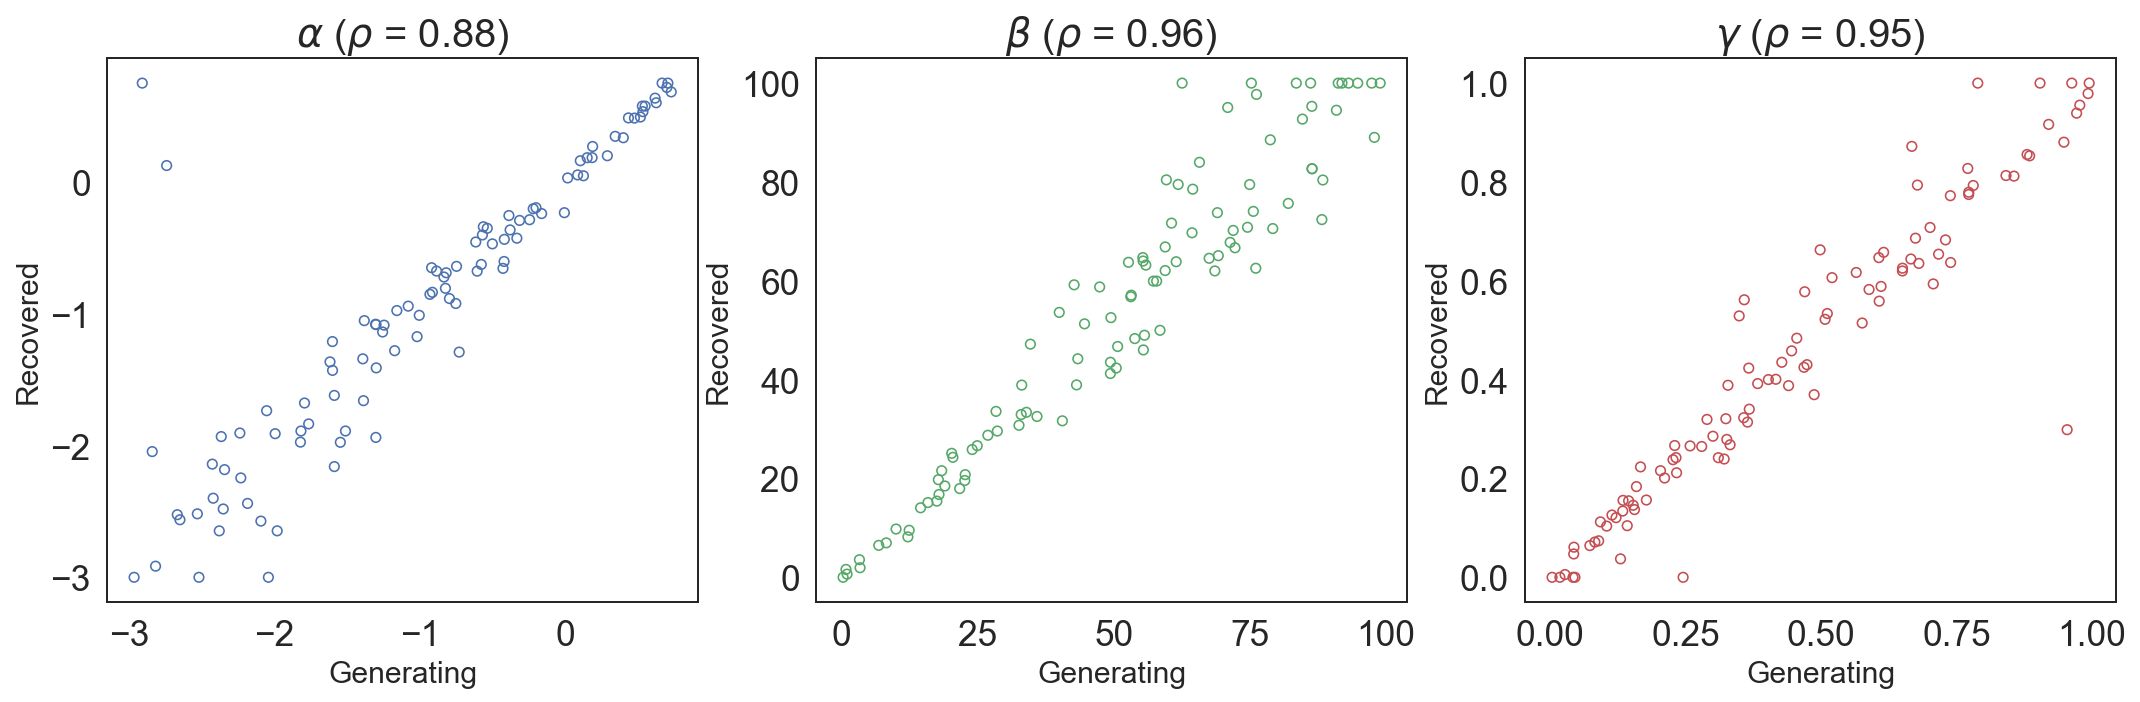

In [16]:
plot_param_recov(params_df, pr_1)
#plt.savefig(f'fig/param_recovery_reference_{model.__name__}.pdf')

## Run for restricted range of probabilities

In [17]:
plim_df = df.copy()

np.random.seed(111)

plim_df['pHa'] = np.random.uniform(0.15, 0.17)
plim_df['pHb'] = np.random.uniform(0.15, 0.17)

display(plim_df.head())

,ContextID,Ha,pHa,La,Hb,pHb,Lb
0,0,141.825526,0.162243,21.930833,165.389371,0.153381,8.159822
1,1,53.371749,0.162243,12.456743,100.648429,0.153381,12.410870
2,2,62.178899,0.162243,30.819660,91.138030,0.153381,6.681652
3,3,61.093635,0.162243,39.110203,176.085447,0.153381,48.565833
4,4,136.591074,0.162243,21.223258,54.117194,0.153381,6.055652


In [18]:
plimparams_df = sim_recov(plim_df)
plimparams_df.name = "plimparams_df"

  0%|          | 0/100 [00:00<?, ?it/s]

Then define some metadata that help with plotting the results, namely saving the distributions where data was sampled from.

In [19]:
dict_metadata[plimparams_df.name] = (plim_df, plimparams_df)

In [20]:
pmin = round(plim_df[["pHa", "pHb"]].min(axis=1).mean(), 2) 
pmax = round(plim_df[["pHa", "pHb"]].max(axis=1).mean(), 2)

plimparams_df.attrs['tag'] = "$p_{high} \in$ " \
                            + f"[{pmin}, {pmax}]"

Calculate Pearson correlation coefficient for this dataset.

In [21]:
pr_2 = get_pearson_r(plimparams_df)

Plot the results.

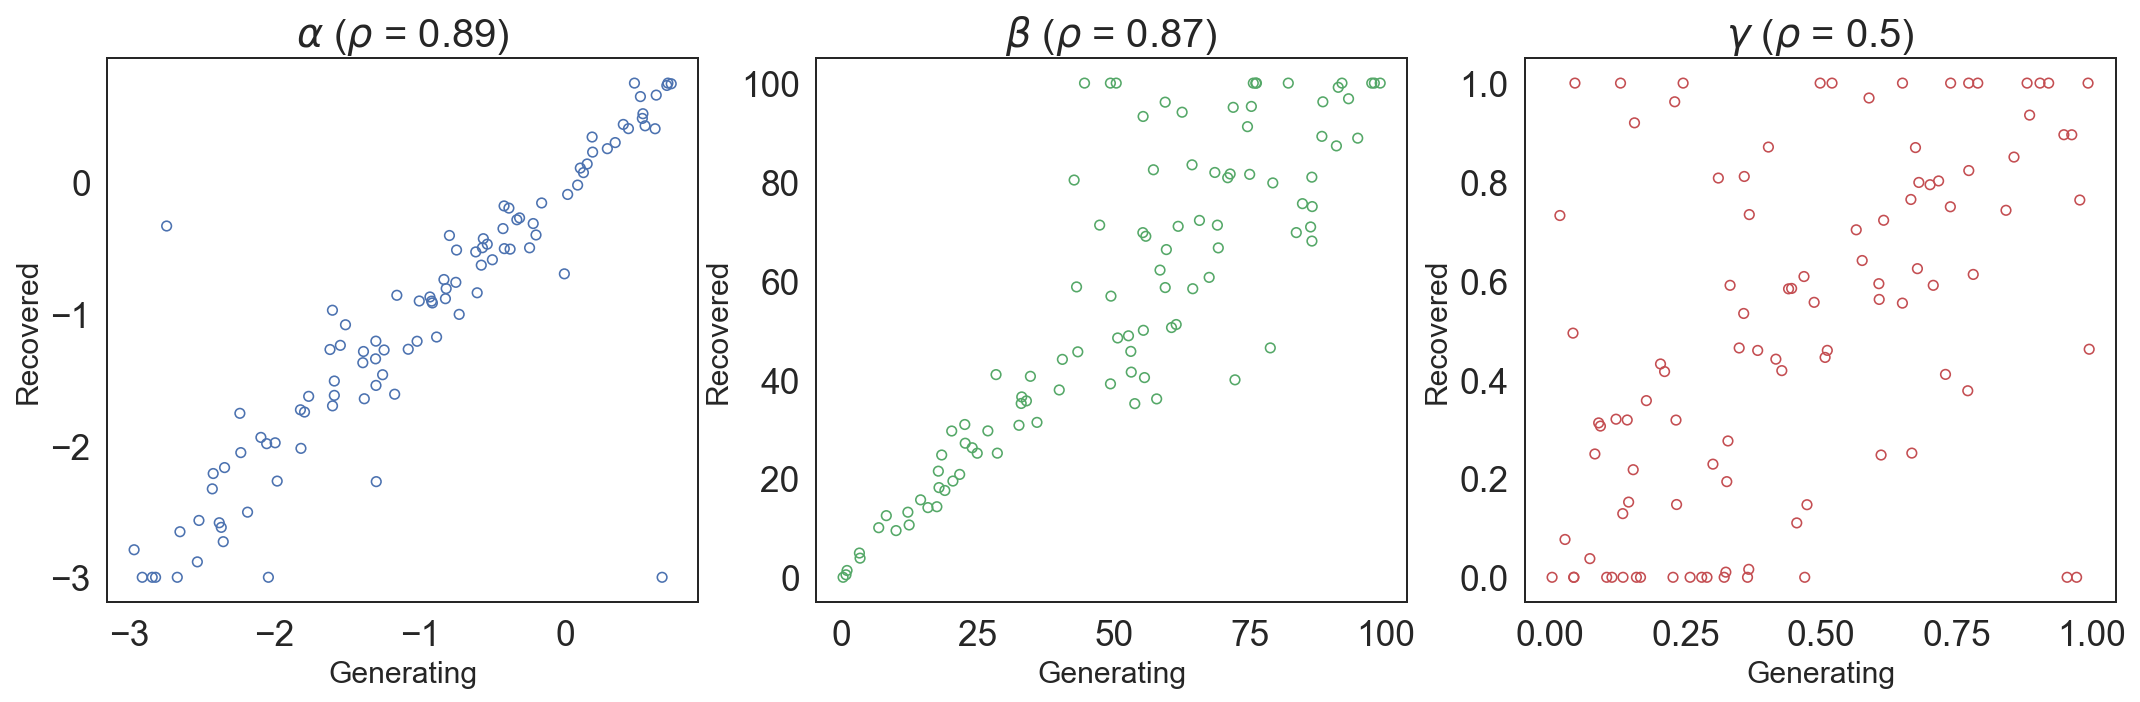

In [22]:
plot_param_recov(plimparams_df, pr_2)
#plt.savefig(f'fig/param_recovery_plim_{model.__name__}.pdf')

## Run for restricted range of outcomes

In [23]:
rlim_df = df.copy()

np.random.seed(111)

low_range = {'lower_bound': 0, 'upper_bound': 5}
high_range = {'lower_bound': 105, 'upper_bound': 110}

rlim_df['Ha'] = np.random.uniform(high_range['lower_bound'], high_range['upper_bound'])
rlim_df['La'] = np.random.uniform(low_range['lower_bound'], low_range['upper_bound'])
rlim_df['Hb'] = np.random.uniform(high_range['lower_bound'], high_range['upper_bound'])
rlim_df['Lb'] = np.random.uniform(low_range['lower_bound'], low_range['upper_bound'])

display(rlim_df.head())

,ContextID,Ha,pHa,La,Hb,pHb,Lb
0,0,108.060851,0.169070,0.845349,107.180295,0.295325,3.846312
1,1,108.060851,0.420224,0.845349,107.180295,0.990712,3.846312
2,2,108.060851,0.669600,0.845349,107.180295,0.466221,3.846312
3,3,108.060851,0.900774,0.845349,107.180295,0.815207,3.846312
4,4,108.060851,0.813767,0.845349,107.180295,0.454137,3.846312


In [24]:
rlimparams_df = sim_recov(rlim_df)
rlimparams_df.name = "rlimparams_df"

  0%|          | 0/100 [00:00<?, ?it/s]

Then define some metadata that help with plotting the results, namely saving the distributions where data was sampled from.

In [25]:
dict_metadata[rlimparams_df.name] = (rlim_df, rlimparams_df)

In [26]:
rlow_min = round(rlim_df[["La", "Lb"]].min(axis=1).mean(), 2) 
rlow_max = round(rlim_df[["La", "Lb"]].max(axis=1).mean(), 2)

rhigh_min = round(rlim_df[["Ha", "Hb"]].min(axis=1).mean(), 2)
rhigh_max = round(rlim_df[["Ha", "Hb"]].max(axis=1).mean(), 2)



rlimparams_df.attrs['tag'] = "$r_{low} \in$ " \
                            + f"[{rlow_min}, {rlow_max}] \n"\
                            + "$r_{high} \in$ " \
                            + f"[{rhigh_min}, {rhigh_max}] "

Calculate Pearson correlation coefficient for this dataset.

In [27]:
pr_3 = get_pearson_r(rlimparams_df)

Plot the results.

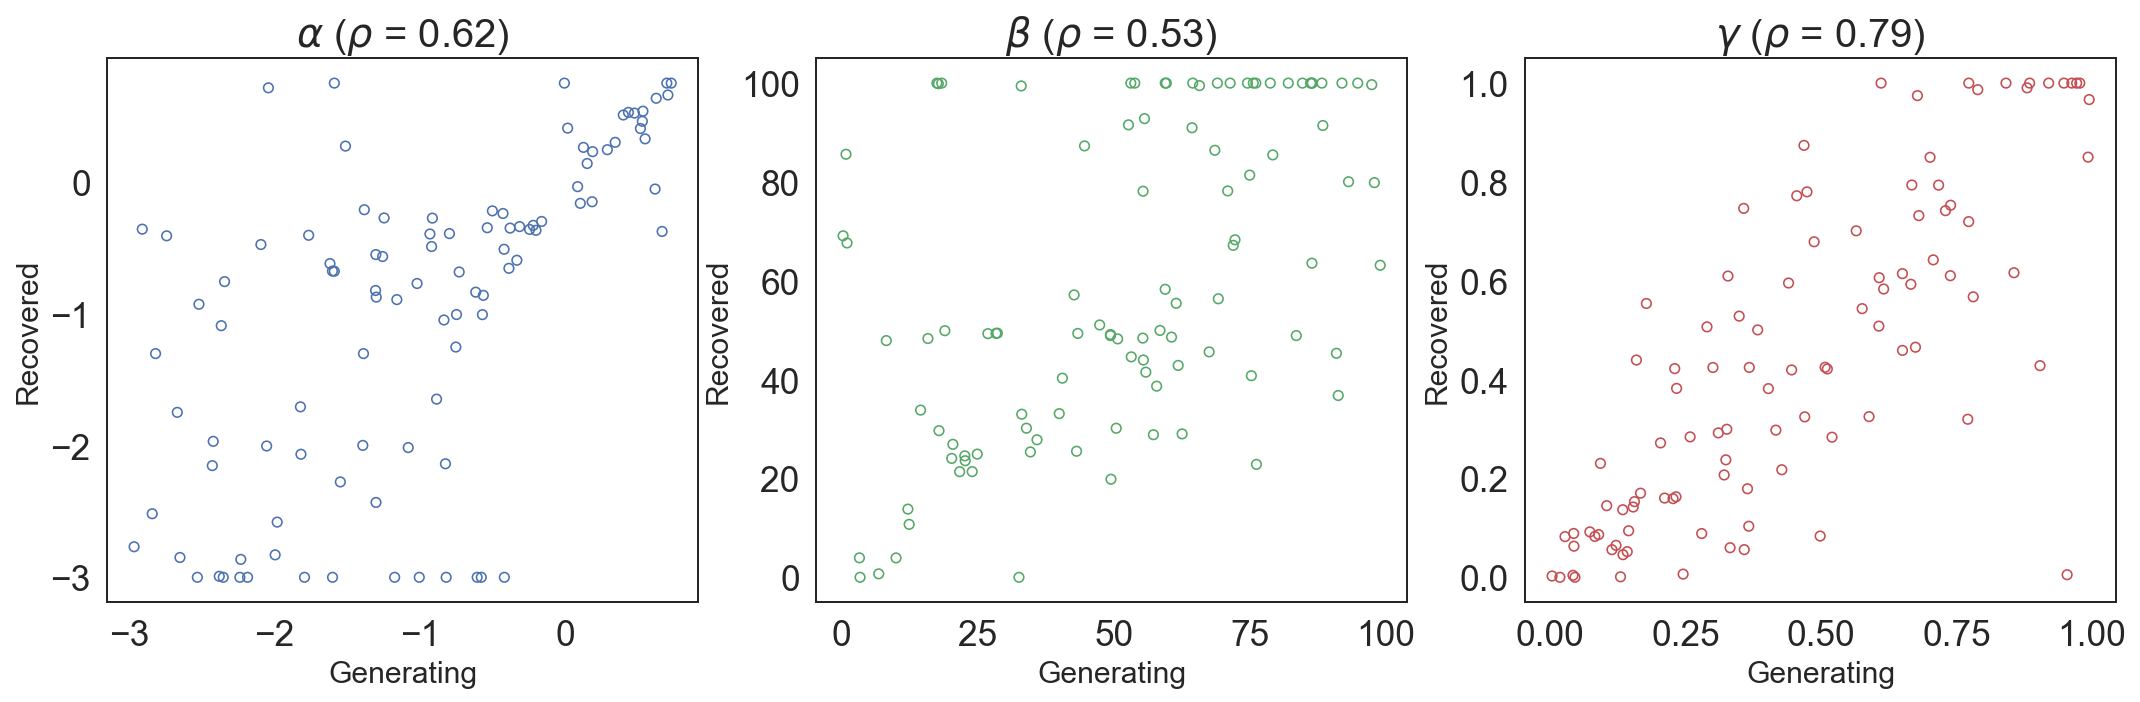

In [28]:
plot_param_recov(rlimparams_df, pr_3)
#plt.savefig(f'fig/param_recovery_rlim_{model.__name__}.pdf')

## Run for restricted number of choices

In [29]:
n_range = {'lower_bound': 1, 'upper_bound': 10}

np.random.seed(111)

nlim_df = df.copy().iloc[n_range['lower_bound']:n_range['upper_bound']]
nlimparams_df = sim_recov(nlim_df)
nlimparams_df.name = "nlimparams_df"

  0%|          | 0/100 [00:00<?, ?it/s]

Then define some metadata that help with plotting the results, namely saving the distributions where data was sampled from.

In [30]:
dict_metadata[nlimparams_df.name] = (nlim_df, nlimparams_df)

In [31]:
nlimparams_df.attrs['tag'] = "$n_{choices}=$" + f"{len(nlim_df)}"

Calculate Pearson correlation coefficient for this dataset.

In [32]:
pr_4 = get_pearson_r(nlimparams_df)

Plot the results.

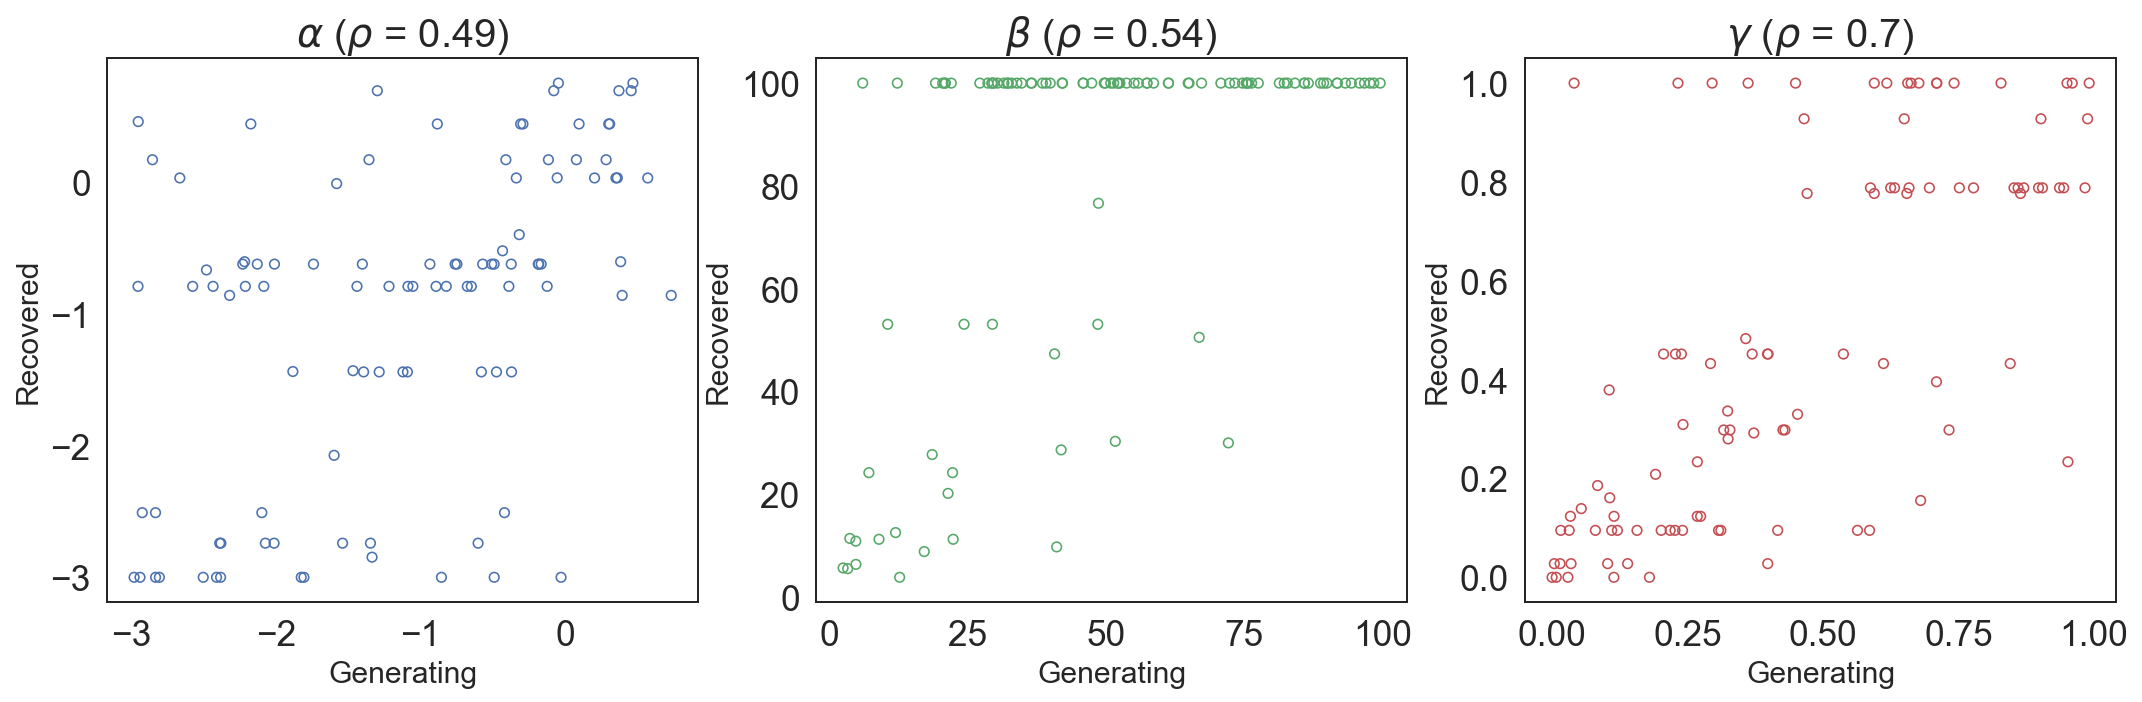

In [33]:
plot_param_recov(nlimparams_df, pr_4)
#plt.savefig(f'fig/param_recovery_nlim_{model.__name__}.pdf')

## Plot all results (Figures 8 and 9)

The cells below are used to plot the results for simulations with all four datasets to the same figure (Figures 8 and 9 in the manuscript). 
Note that this figure is saved to a separate folder.

In [34]:
def plot_param_recov_all(df: pd.DataFrame, pr: Dict, param_lbl: string, col: string, marker: string, ax: plt.Axes):
    
    '''
    Function for plotting results for each ax.
    
    Parameters
    ----------
    df: pd.DataFrame
        data to be plotted
    pr : Dict
        Pearson correlation coefficients for the plotted data
    param_lbl : string
        parameter label of the plotted data
    col : string
        colour corresponding to the parameter being plotted
    marker : string
        marker corresponding to whether parameter recovery is sufficient
    ax : plt.Axes
        empty axis
    
    Returns
    -------
    ax : plt.Axes
        axis where data is plotted
    
    '''

    alpha = 0.5
    
    x = df[f'gen_{param_lbl}']
    y = df[f'rec_{param_lbl}']
    ax.scatter(x, y, alpha=alpha, color=col, marker=marker, s = 70)
    
    if param_lbl == "$\\alpha$":
                ax.plot(
                    [-3, 0.51],
                    [-3, 0.51],
                    linestyle="--", alpha=0.2, color="black", zorder=-10)
    elif param_lbl == "$\\beta$":
                ax.plot(
                    [1, 101],
                    [1, 101],
                    linestyle="--", alpha=0.2, color="black", zorder=-10)
    elif param_lbl == "$\\gamma$":
                ax.plot(
                    [0, 1],
                    [0, 1],
                    linestyle="--", alpha=0.2, color="black", zorder=-10)
    
    return ax

In [35]:
def plot_all(df_list: list):
    
    '''
    Main function for plotting results for all datasets.
    
    Parameters
    ----------
    df_list : list
        list of pd.DataFrame objects to be plotted
    '''
    
    title_size = 20
    lbl_size = 25
    
    if model == P_EUT:
        figsize = (15,20)
        x = 0.35
    elif model == P_CPT:
        figsize = (20,20)
        x = 0.28
    
    fig, axs = plt.subplots(nrows=len(df_list), ncols=len(labels) + 1, figsize=figsize)
    
    for r, df in enumerate(df_list):
        pr = get_pearson_r(df)
        for c, param_lbl in enumerate(labels):
            
            c = c+1
            
            if pr[param_lbl] < 0.7:
                col = 'grey'
                marker = 'x'
            else:
                col = c_vec[param_lbl]
                marker = 'o'

            plot_param_recov_all(df, pr, param_lbl, col, marker, axs[r,c])
            
            # Set title to param
            if r == 0 and (c == 1 or c == 2 or c == 3):
                axs[r,c].set_title(f"{param_lbl}\n($\\rho$ = {round(pr[param_lbl],2)})", size=title_size)
            else: 
                axs[r,c].set_title(f"($\\rho$ = {round(pr[param_lbl],2)})", size=title_size)

            
            axs[r, 0].text(0, 0.2, df.attrs['tag'] , size=17)
            axs[r, 0].axis('off')
            axs[r, 0].text(-0.3, 0.5, string.ascii_uppercase[r], size=lbl_size)
        
        
        fig.text(x, 0.45, 'Recovered $\\in \\hat{\\theta}$', ha='center',rotation='vertical', size= lbl_size)
        fig.text(0.55, 0.08, 'Generating $\\in \\theta$', va='center', size= lbl_size)
        fig.suptitle(f"{model.__name__} ".replace('_', '-'), fontweight="bold", fontsize=30, y = 0.95, x=0.6)

In [36]:
def create_labels(df: string, display_tag: bool = False):
    
    '''
    Creates labels based on metadata.
    
    Parameters
    ----------
    df : pd.DataFrame
        dataframe where the information is obtained from
    display_tag: bool
        boolean indicating whether to show tag at the end of creating lables
    '''
    df_name = df.name
    df = dict_metadata[df_name][0]
    df_param = dict_metadata[df_name][1]
    

    pmin = round(min([df.pHa.min(), df.pHb.min()]), 2) 
    pmax = round(max([df.pHa.max(), df.pHb.max()]), 2) 
    rlow_min = round(min([df.La.min(), df.Lb.min()]), 2) 
    rlow_max = round(max([df.La.max(), df.Lb.max()]),2) 
    rhigh_min = round(min([df.Ha.min(), df.Hb.min()]),2)
    rhigh_max = round(max([df.Ha.max(), df.Hb.max()]),2) 

    df_param.attrs['tag'] = '$n_{choices}=$' + f"{len(df)}\n" \
                                    + "$p_{high} \in$" + f"[{pmin}, {pmax}]\n" \
                                    + "$x_{low} \in$ " \
                                    + f"[{rlow_min}, {rlow_max}]\n"\
                                    + "$x_{high} \in$ " \
                                    + f"[{rhigh_min}, {rhigh_max}] "

    if display_tag:
        display(df_param.attrs['tag'])

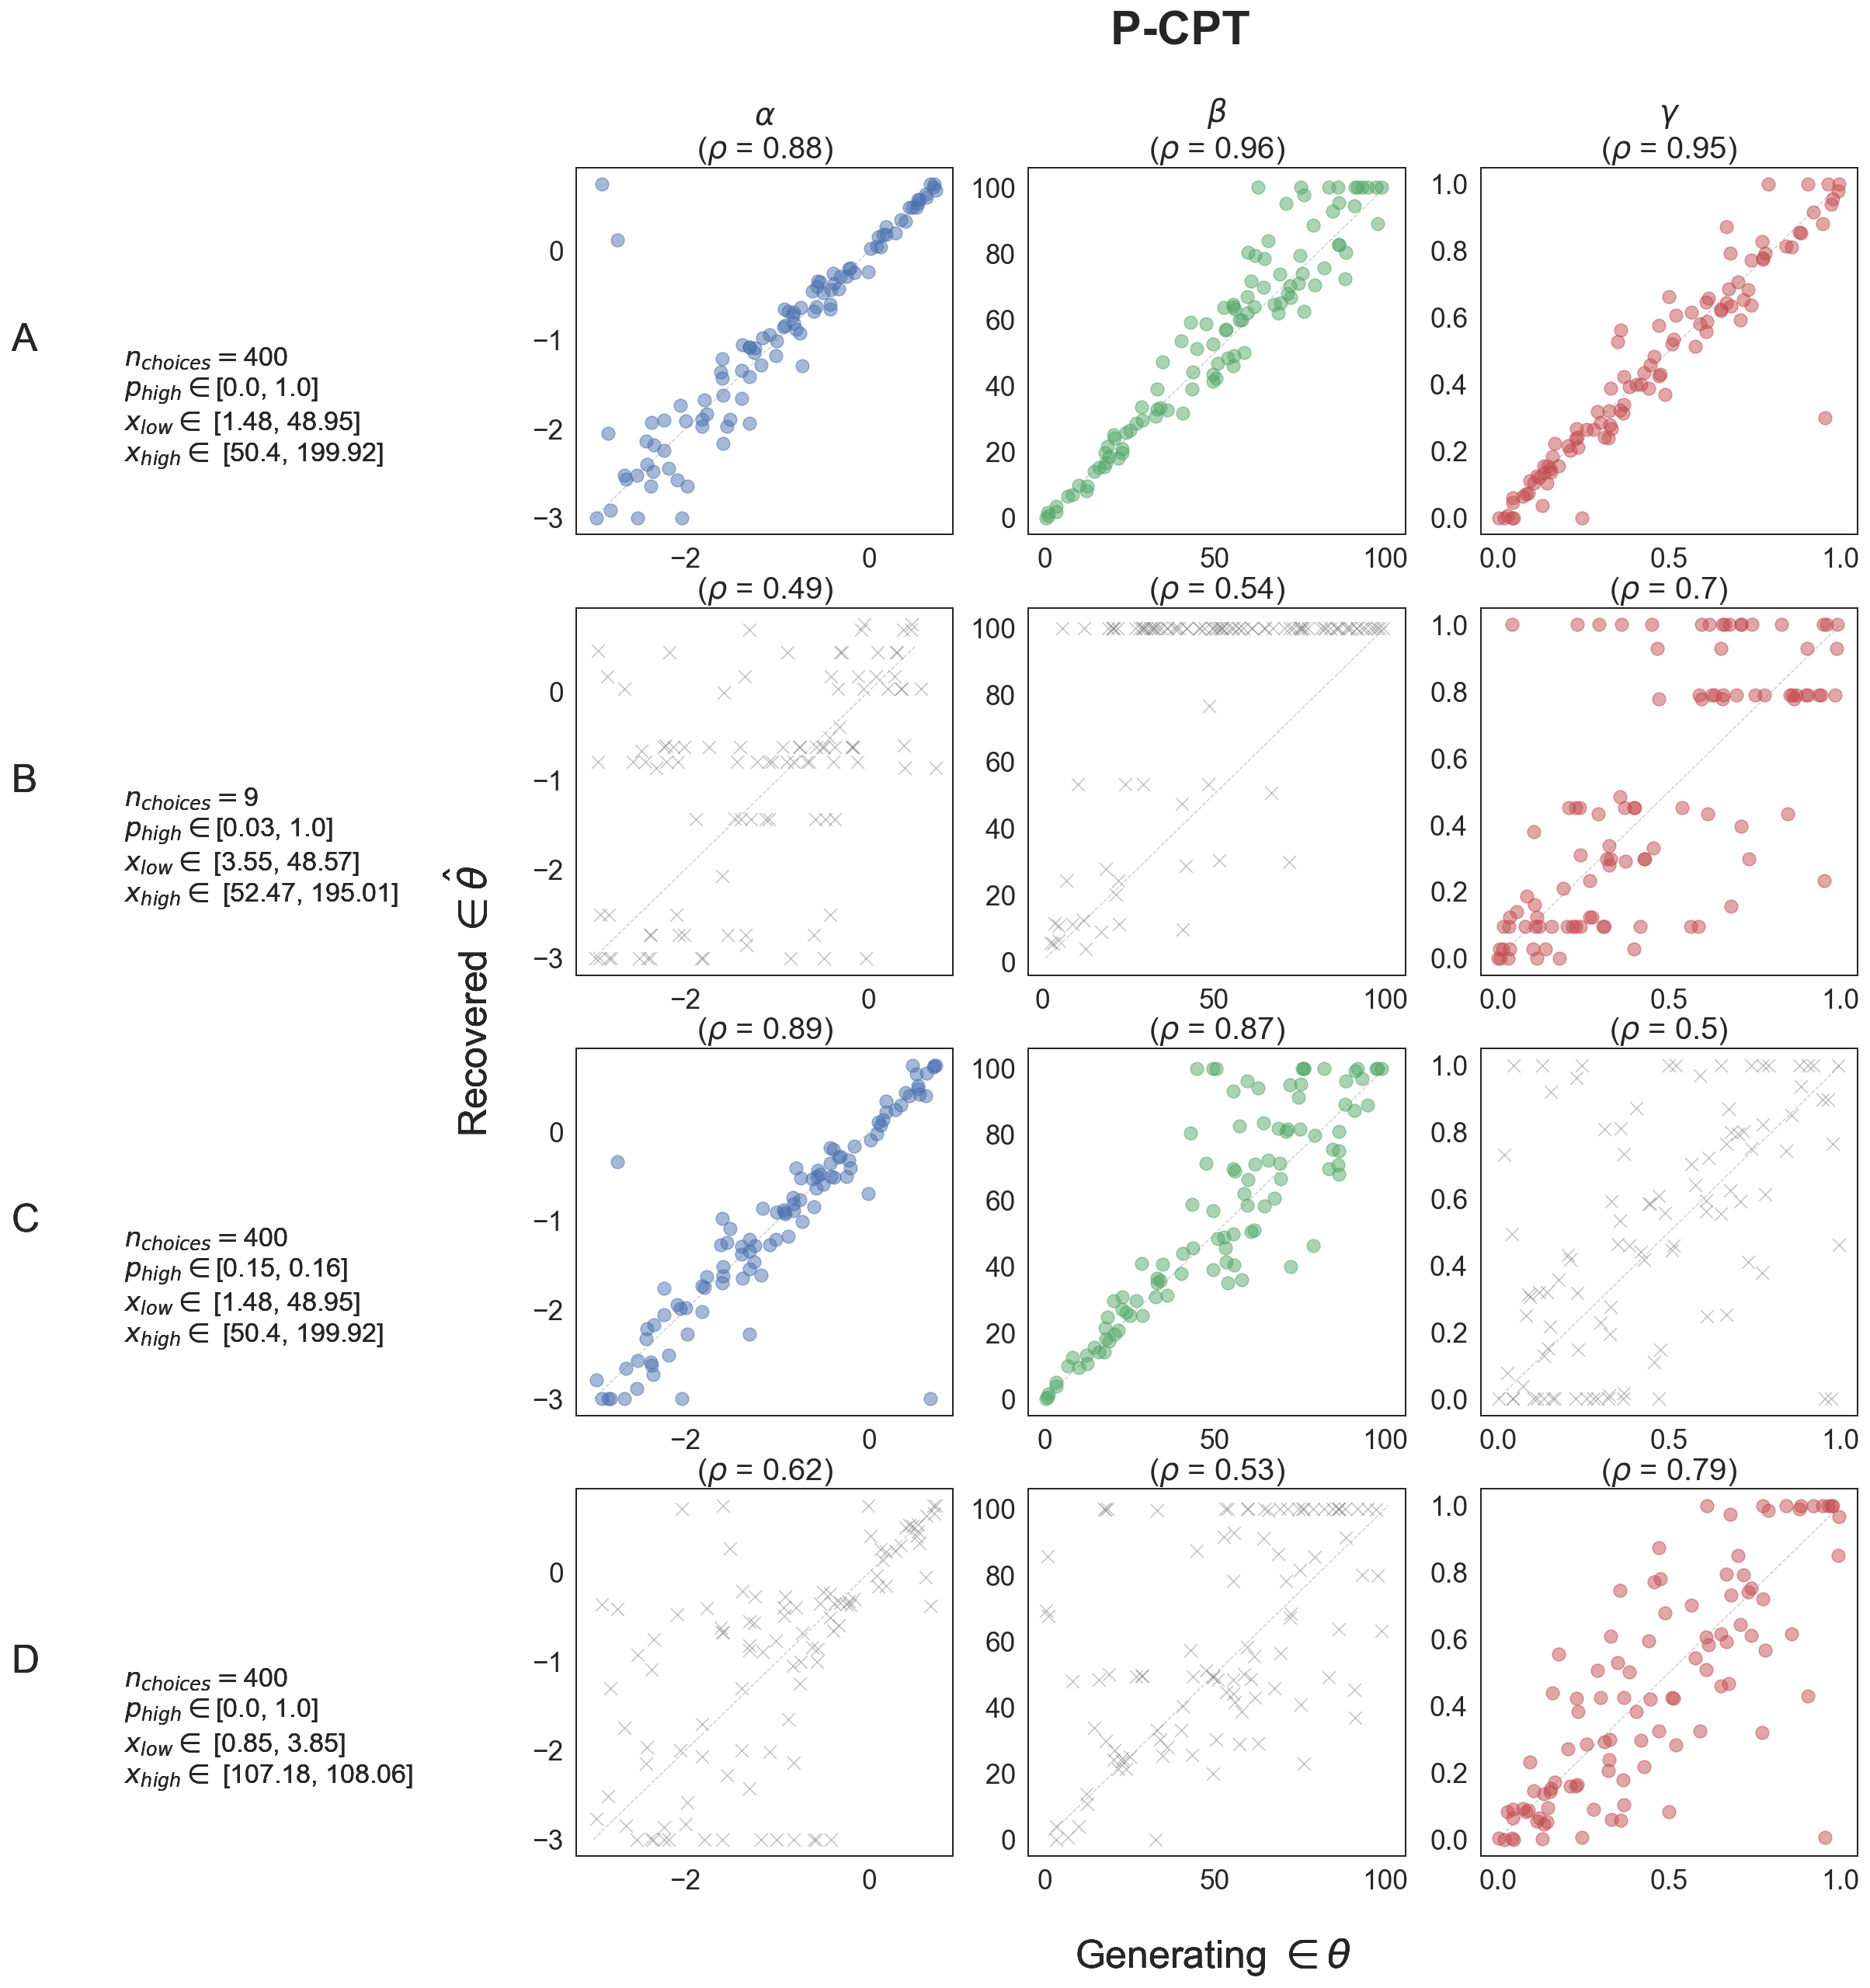

In [37]:
df_list = [params_df, nlimparams_df, plimparams_df, rlimparams_df]

for df in df_list:
    create_labels(df)

plot_all(df_list)
plt.savefig(f'fig/param_recovery_all_{model.__name__}.pdf', bbox_inches='tight')